In [1]:
from gurobipy import *
import math
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import re

We create the graph with its nodes, edges, and attributes

Graph with 13 nodes and 18 edges
[(0, {'S': 0}), (1, {'S': 1}), (2, {'S': 0}), (3, {'S': 1}), (4, {'S': 1}), (5, {'S': 0}), (6, {'S': 0}), (7, {'S': 0}), (8, {'S': 1}), (9, {'S': 1}), (10, {'S': 0}), (11, {'S': 0}), (12, {'S': 0})]
[(0, 1), (0, 2), (1, 3), (1, 4), (2, 3), (3, 6), (3, 8), (4, 5), (4, 6), (5, 7), (6, 7), (6, 9), (8, 9), (8, 10), (8, 11), (9, 10), (9, 12), (11, 12)]


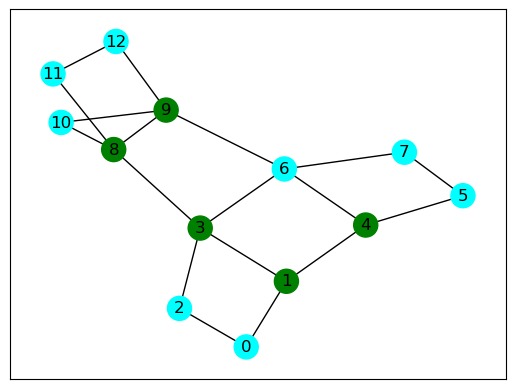

In [2]:
V=nx.Graph()
N=5
for k in range(13):
    V.add_node(k)
V.add_edges_from([(0,1),(0,2),(2,3),(1,3),(1,4),(4,5),(5,7),(3,6),(4,6),(6,7),(3,8),(6,9),(8,9),(8,10),(9,10),(8,11),(9,12),(11,12)])
print(V)
#13498
V.nodes[0]['S']=0
V.nodes[1]['S']=1
V.nodes[2]['S']=0
V.nodes[3]['S']=1
V.nodes[4]['S']=1
V.nodes[5]['S']=0
V.nodes[6]['S']=0
V.nodes[7]['S']=0
V.nodes[8]['S']=1
V.nodes[9]['S']=1
V.nodes[10]['S']=0
V.nodes[11]['S']=0
V.nodes[12]['S']=0
print(V.nodes.data())
print(V.edges())
color_map=[]
for i in V.nodes():
    if V.nodes[i]['S']==1:
        color_map.append('green')
    else:
        color_map.append('cyan')
nx.draw_networkx(V, with_labels=True,node_color=color_map)

In [3]:
nw_mod=Model(name="nw")
N=5
C=100
c=10
T=50
t=30

delta_ij = nw_mod.addVars(V.number_of_nodes(),V.number_of_nodes(),name='delta_{i}_{j}',vtype=GRB.BINARY)
x=nw_mod.addVars(V.number_of_nodes(),name='x',vtype=GRB.BINARY)
y=nw_mod.addVars(V.number_of_nodes(),name='y',vtype=GRB.BINARY)
z=nw_mod.addVars(V.number_of_nodes(),name='z',vtype=GRB.BINARY)
u=nw_mod.addVars(V.number_of_nodes(),name='u',vtype=GRB.BINARY)
a=nw_mod.addVars(V.number_of_nodes(),name='a',vtype=GRB.BINARY)
b=nw_mod.addVars(V.number_of_nodes(),name='b',vtype=GRB.BINARY)
w=nw_mod.addVars(V.number_of_nodes(),name='w',vtype=GRB.BINARY)

obj_fun=sum(c*delta_ij[i,j] for i,j in V.edges())+sum(t*u[k] for k in V.nodes())
nw_mod.setObjective(obj_fun, GRB.MINIMIZE)

for i in V.nodes():
    nw_mod.addConstr(x[i] + y[i] + z[i] == 1, 'constraint_one_subd{i}')
    
for i in V.nodes():
    nw_mod.addConstr(2*a[i]<=u[i]+x[i],'constraint_ui_xi')
    nw_mod.addConstr(2*b[i]<=u[i]+y[i],'constraint_ui_yi')
    nw_mod.addConstr(2*w[i]<=u[i]+z[i],'constraint_ui_zi')

    nw_mod.addConstr(1+2*a[i]>=u[i]+x[i],'constraint_ui_xi_2')
    nw_mod.addConstr(1+2*b[i]>=u[i]+y[i],'constraint_ui_yi_2')
    nw_mod.addConstr(1+2*w[i]>=u[i]+z[i],'constraint_ui_zi_2')

#nw_mod.addConstr(sum(x[i] for i in V.nodes())>=sum(y[i] for i in V.nodes()),'constraint_max_x')
#nw_mod.addConstr(sum(y[i] for i in V.nodes())>=sum(z[i] for i in V.nodes()),'constraint_max_y')

#nw_mod.addConstr(sum(x[i] for i in V.nodes())>=sum(y[i] for i in V.nodes())+sum(z[i] for i in V.nodes()),'constraint_max_x')

nw_mod.addConstr(sum(V.nodes[i]['S'] * (x[i]-a[i]) for i in V.nodes()) <= (math.ceil(N/2)) - 1, 'constraint_sum_S_x')
nw_mod.addConstr(sum(V.nodes[i]['S'] * (y[i]-b[i]) for i in V.nodes()) <= (math.ceil(N/2)) - 1, 'constraint_sum_S_y')
nw_mod.addConstr(sum(V.nodes[i]['S'] * (z[i]-w[i]) for i in V.nodes()) <= (math.ceil(N/2)) - 1, 'constraint_sum_S_z')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-29


<gurobi.Constr *Awaiting Model Update*>

In [4]:

for i, j in V.edges():
    nw_mod.addConstr(delta_ij[i, j] <= 2 - x[i] - x[j], f'constraint_delta_ij_x_{i}_{j}_same_x')
    nw_mod.addConstr(delta_ij[j, i] <= 2 - x[i] - x[j], f'constraint_delta_ij_x_{i}_{j}_same_x_2')
    nw_mod.addConstr(delta_ij[i, j] <= 2 - y[i] - y[j], f'constraint_delta_ij_x_{i}_{j}_same_y')
    nw_mod.addConstr(delta_ij[j, i] <= 2 - y[i] - y[j], f'constraint_delta_ij_x_{i}_{j}_same_y_2')
    nw_mod.addConstr(delta_ij[i, j] <= 2 - z[i] - z[j], f'constraint_delta_ij_x_{i}_{j}_same_z')
    nw_mod.addConstr(delta_ij[j, i] <= 2 - z[i] - z[j], f'constraint_delta_ij_x_{i}_{j}_same_z_2')
    nw_mod.addConstr(delta_ij[i, j] >= x[i] - x[j], f'constraint_delta_ij_x_{i}_{j}_not_same_x')
    nw_mod.addConstr(delta_ij[i, j] >= x[j] - x[i], f'constraint_delta_ij_x_{i}_{j}_not_same_x_2')
    nw_mod.addConstr(delta_ij[i, j] >= y[i] - y[j], f'constraint_delta_ij_x_{i}_{j}_not_same_y')
    nw_mod.addConstr(delta_ij[i, j] >= y[j] - y[i], f'constraint_delta_ij_x_{i}_{j}_not_same_y_2')
    nw_mod.addConstr(delta_ij[i, j] >= z[i] - z[j], f'constraint_delta_ij_x_{i}_{j}_not_same_z')
    nw_mod.addConstr(delta_ij[i, j] >= z[j] - z[i], f'constraint_delta_ij_x_{i}_{j}_not_same_z_2')


In [5]:



#nw_mod.setParam('OutputFlag',False)
nw_mod.optimize()
#nw_mod.computeIIS()
print (nw_mod.display())
print('Optimization is done. Objective function value: %.2f' % nw_mod.objVal)
for v in nw_mod.getVars():
    print ('%s: %g' % (v.varName,v.x))

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 310 rows, 260 columns and 951 nonzeros
Model fingerprint: 0x1c05133a
Variable types: 0 continuous, 260 integer (260 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 180.0000000
Presolve removed 102 rows and 183 columns
Presolve time: 0.00s
Presolved: 208 rows, 77 columns, 645 nonzeros
Variable types: 0 continuous, 77 integer (77 binary)
Found heuristic solution: objective 150.0000000

Root relaxation: objective 0.000000e+00, 38 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl | 

 b[4] + -1.0 b[8] + -1.0 b[9] <= 2
constraint_sum_S_z: z[1] + z[3] + z[4] + z[8] + z[9] + -1.0 w[1] + -1.0 w[3] + -1.0
 w[4] + -1.0 w[8] + -1.0 w[9] <= 2
  constraint_delta_ij_x_0_1_same_x: delta_{i}_{j}[0,1] + x[0] + x[1] <= 2
  constraint_delta_ij_x_0_1_same_x_2: delta_{i}_{j}[1,0] + x[0] + x[1] <= 2
  constraint_delta_ij_x_0_1_same_y: delta_{i}_{j}[0,1] + y[0] + y[1] <= 2
  constraint_delta_ij_x_0_1_same_y_2: delta_{i}_{j}[1,0] + y[0] + y[1] <= 2
  constraint_delta_ij_x_0_1_same_z: delta_{i}_{j}[0,1] + z[0] + z[1] <= 2
  constraint_delta_ij_x_0_1_same_z_2: delta_{i}_{j}[1,0] + z[0] + z[1] <= 2
  constraint_delta_ij_x_0_1_not_same_x: delta_{i}_{j}[0,1] + -1.0 x[0] + x[1] >= 0
  constraint_delta_ij_x_0_1_not_same_x_2: delta_{i}_{j}[0,1] + x[0] + -1.0 x[1] >= 0
  constraint_delta_ij_x_0_1_not_same_y: delta_{i}_{j}[0,1] + -1.0 y[0] + y[1] >= 0
  constraint_delta_ij_x_0_1_not_same_y_2: delta_{i}_{j}[0,1] + y[0] + -1.0 y[1] >= 0
  constraint_delta_ij_x_0_1_not_same_z: delta_{i}_{j}[0,1] +

  constraint_delta_ij_x_4_6_not_same_x: delta_{i}_{j}[4,6] + -1.0 x[4] + x[6] >= 0
  constraint_delta_ij_x_4_6_not_same_x_2: delta_{i}_{j}[4,6] + x[4] + -1.0 x[6] >= 0
  constraint_delta_ij_x_4_6_not_same_y: delta_{i}_{j}[4,6] + -1.0 y[4] + y[6] >= 0
  constraint_delta_ij_x_4_6_not_same_y_2: delta_{i}_{j}[4,6] + y[4] + -1.0 y[6] >= 0
  constraint_delta_ij_x_4_6_not_same_z: delta_{i}_{j}[4,6] + -1.0 z[4] + z[6] >= 0
  constraint_delta_ij_x_4_6_not_same_z_2: delta_{i}_{j}[4,6] + z[4] + -1.0 z[6] >= 0
  constraint_delta_ij_x_5_7_same_x: delta_{i}_{j}[5,7] + x[5] + x[7] <= 2
  constraint_delta_ij_x_5_7_same_x_2: delta_{i}_{j}[7,5] + x[5] + x[7] <= 2
  constraint_delta_ij_x_5_7_same_y: delta_{i}_{j}[5,7] + y[5] + y[7] <= 2
  constraint_delta_ij_x_5_7_same_y_2: delta_{i}_{j}[7,5] + y[5] + y[7] <= 2
  constraint_delta_ij_x_5_7_same_z: delta_{i}_{j}[5,7] + z[5] + z[7] <= 2
  constraint_delta_ij_x_5_7_same_z_2: delta_{i}_{j}[7,5] + z[5] + z[7] <= 2
  constraint_delta_ij_x_5_7_not_same_x: delta_

C:\Users\rodri\AppData\Local\Temp\ipykernel_33848\2754967582.py:4: DeprecationWarning: Model.display() is deprecated
  print (nw_mod.display())


  constraint_delta_ij_x_8_9_same_z_2: delta_{i}_{j}[9,8] + z[8] + z[9] <= 2
  constraint_delta_ij_x_8_9_not_same_x: delta_{i}_{j}[8,9] + -1.0 x[8] + x[9] >= 0
  constraint_delta_ij_x_8_9_not_same_x_2: delta_{i}_{j}[8,9] + x[8] + -1.0 x[9] >= 0
  constraint_delta_ij_x_8_9_not_same_y: delta_{i}_{j}[8,9] + -1.0 y[8] + y[9] >= 0
  constraint_delta_ij_x_8_9_not_same_y_2: delta_{i}_{j}[8,9] + y[8] + -1.0 y[9] >= 0
  constraint_delta_ij_x_8_9_not_same_z: delta_{i}_{j}[8,9] + -1.0 z[8] + z[9] >= 0
  constraint_delta_ij_x_8_9_not_same_z_2: delta_{i}_{j}[8,9] + z[8] + -1.0 z[9] >= 0
  constraint_delta_ij_x_8_10_same_x: delta_{i}_{j}[8,10] + x[8] + x[10] <= 2
  constraint_delta_ij_x_8_10_same_x_2: delta_{i}_{j}[10,8] + x[8] + x[10] <= 2
  constraint_delta_ij_x_8_10_same_y: delta_{i}_{j}[8,10] + y[8] + y[10] <= 2
  constraint_delta_ij_x_8_10_same_y_2: delta_{i}_{j}[10,8] + y[8] + y[10] <= 2
  constraint_delta_ij_x_8_10_same_z: delta_{i}_{j}[8,10] + z[8] + z[10] <= 2
  constraint_delta_ij_x_8_10_sa

'delta_{i}_{j}[9,1]', 'delta_{i}_{j}[9,2]', 'delta_{i}_{j}[9,3]', 'delta_{i}_{j}[9,4]',
'delta_{i}_{j}[9,5]', 'delta_{i}_{j}[9,6]', 'delta_{i}_{j}[9,7]', 'delta_{i}_{j}[9,8]',
'delta_{i}_{j}[9,9]', 'delta_{i}_{j}[9,10]', 'delta_{i}_{j}[9,11]',
'delta_{i}_{j}[9,12]', 'delta_{i}_{j}[10,0]', 'delta_{i}_{j}[10,1]',
'delta_{i}_{j}[10,2]', 'delta_{i}_{j}[10,3]', 'delta_{i}_{j}[10,4]',
'delta_{i}_{j}[10,5]', 'delta_{i}_{j}[10,6]', 'delta_{i}_{j}[10,7]',
'delta_{i}_{j}[10,8]', 'delta_{i}_{j}[10,9]', 'delta_{i}_{j}[10,10]',
'delta_{i}_{j}[10,11]', 'delta_{i}_{j}[10,12]', 'delta_{i}_{j}[11,0]',
'delta_{i}_{j}[11,1]', 'delta_{i}_{j}[11,2]', 'delta_{i}_{j}[11,3]',
'delta_{i}_{j}[11,4]', 'delta_{i}_{j}[11,5]', 'delta_{i}_{j}[11,6]',
'delta_{i}_{j}[11,7]', 'delta_{i}_{j}[11,8]', 'delta_{i}_{j}[11,9]',
'delta_{i}_{j}[11,10]', 'delta_{i}_{j}[11,11]', 'delta_{i}_{j}[11,12]',
'delta_{i}_{j}[12,0]', 'delta_{i}_{j}[12,1]', 'delta_{i}_{j}[12,2]',
'delta_{i}_{j}[12,3]', 'delta_{i}_{j}[12,4]', 'delta_{i}_{j}

In [6]:
deltas={}
x_arr={}
y_arr={}
z_arr={}
u_arr={}
for v in nw_mod.getVars():
    if re.match('delta',v.varName) is not None and v.x!=0:
        deltas[v.varName]=v.x
    if re.match('u',v.varName) is not None and v.x!=0:
        u_arr[v.varName]=v.x
    if re.match('x',v.varName) is not None:
        x_arr[v.varName]=v.x
    if re.match('y',v.varName) is not None:
        y_arr[v.varName]=v.x
    if re.match('z',v.varName) is not None:
        z_arr[v.varName]=v.x

print('Optimization is done. Objective function value: %.2f' % nw_mod.objVal)
dfdelta=pd.DataFrame.from_dict(deltas,orient='index')
dfu=pd.DataFrame.from_dict(u_arr,orient='index')
#print(dfdist)
print("List of connections brought down:")
print(dfdelta)
print("List of nodes with DCN service brought down:")
print(dfu)
tmpx=[]
tmpy=[]
tmpz=[]
for i in x_arr:
    
    if x_arr[i]==1:
        tmpx.append(list(x_arr).index(i))
print("Nodes in partition x:")
print(tmpx)
for i in y_arr:
    
    if y_arr[i]==1:
        tmpy.append(list(y_arr).index(i))
print("Nodes in partition y:")
print(tmpy)
for i in z_arr:
    
    if z_arr[i]==1:
        tmpz.append(list(z_arr).index(i))
print("Nodes in partition z:")
print(tmpz)

Optimization is done. Objective function value: 40.00
List of connections brought down:
                      0
delta_{i}_{j}[1,4]  1.0
delta_{i}_{j}[3,6]  1.0
delta_{i}_{j}[3,8]  1.0
delta_{i}_{j}[6,9]  1.0
List of nodes with DCN service brought down:
Empty DataFrame
Columns: []
Index: []
Nodes in partition x:
[0, 1, 2, 3]
Nodes in partition y:
[4, 5, 6, 7]
Nodes in partition z:
[8, 9, 10, 11, 12]


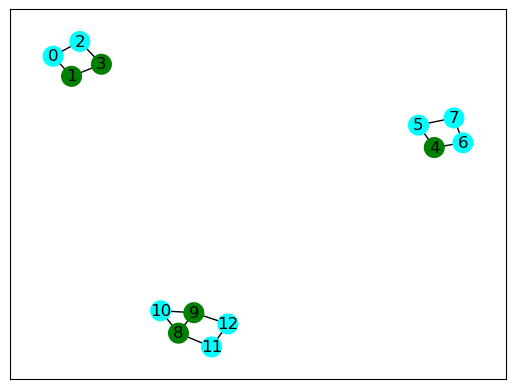

In [15]:
edges_to_remove = []
for i, j in V.edges():

    if delta_ij[i, j].X == 1:
        
        edges_to_remove.append((i, j))
color_map2 = []
for i in V.nodes():
    if u[i].X==1 and V.nodes[i]['S']==1:
        color_map2.append('red')
    elif u[i].X==0 and V.nodes[i]['S']==1:
        color_map2.append('green')
    else:
        color_map2.append('cyan')

for edge in edges_to_remove:
    V.remove_edge(*edge)
#nx.draw(G, with_labels=True, , node_size=800, font_color='white', font_weight='bold')
nx.draw_networkx(V, with_labels=True,node_color=color_map2,node_size=200)